#### This notebook trains our baseline model

Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
os.chdir("../models")
from model import CustomCNN
from common_utils import set_seed, EarlyStopper, train, get_mean_rgb, CustomTransform

# set seed
set_seed(42)

Initialise model and dataset

In [2]:
model = CustomCNN() # initialise model

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=get_mean_rgb(datasets.Flowers102(root='../data', split='test', download=True, transform=transforms.ToTensor())), std=[1,1,1])
])

# load data
train_dataset = datasets.Flowers102(root='../data', split='test', download=True, transform=transform) 
val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=transform) 
test_dataset = datasets.Flowers102(root='../data', split='train', download=True, transform=transform)
# NOTE: Due to a bug with the Flowers102 dataset, the train and test splits are swapped

batch_size = 128
# initialise dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Specify hyperparameters

In [3]:
lr = 0.001 # learning rate
optimiser = torch.optim.Adam(model.parameters(), lr=lr) # initialise optimiser
loss = torch.nn.CrossEntropyLoss() # initialise loss function

if torch.cuda.is_available(): # nvidia gpu
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): # apple gpu
    device = torch.device("mps")
else:
    device = torch.device("cpu")
model.to(device)

epochs = 300 # number of epochs
early_stopper = EarlyStopper(patience=25) # initialise early stopper


# Make directory to save baseline model
baseline_model_path = "./saved_models/baseline_model/non_preprocessed"
if not os.path.exists(baseline_model_path):
    os.mkdir(baseline_model_path)

# Define the device-specific path
device_type = None
if device == torch.device("cuda"):
    device_type = "cuda"
elif device == torch.device("mps"):
    device_type = "mps"
else:
    device_type = "cpu"

# Construct the full path
device_path = os.path.join(baseline_model_path, device_type)

# Create the directory if it doesn't exist
if not os.path.exists(device_path):
    os.mkdir(device_path)

Train the model

In [4]:
train_loss_list, val_loss_list, val_acc_list = train(model, train_dataloader, val_dataloader, optimiser, loss, device, epochs, early_stopper, device_path) # train model

Epoch 1/300:   0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/300: 100%|██████████| 49/49 [01:13<00:00,  1.50s/it, Training loss=4.4630]


Epoch 1/300 took 79.26s | Train loss: 4.4630 | Val loss: 4.8260 | Val accuracy: 1.08% | EarlyStopper count: 0


Epoch 2/300: 100%|██████████| 49/49 [01:03<00:00,  1.29s/it, Training loss=4.2187]


Epoch 2/300 took 68.78s | Train loss: 4.2187 | Val loss: 4.3895 | Val accuracy: 2.75% | EarlyStopper count: 0


Epoch 3/300: 100%|██████████| 49/49 [01:07<00:00,  1.38s/it, Training loss=3.9167]


Epoch 3/300 took 73.67s | Train loss: 3.9167 | Val loss: 4.3284 | Val accuracy: 3.24% | EarlyStopper count: 0


Epoch 4/300: 100%|██████████| 49/49 [01:11<00:00,  1.47s/it, Training loss=3.7663]


Epoch 4/300 took 78.88s | Train loss: 3.7663 | Val loss: 4.0822 | Val accuracy: 4.51% | EarlyStopper count: 0


Epoch 5/300: 100%|██████████| 49/49 [01:11<00:00,  1.47s/it, Training loss=3.6373]


Epoch 5/300 took 77.62s | Train loss: 3.6373 | Val loss: 3.8440 | Val accuracy: 6.37% | EarlyStopper count: 0


Epoch 6/300: 100%|██████████| 49/49 [01:05<00:00,  1.33s/it, Training loss=3.4321]


Epoch 6/300 took 70.98s | Train loss: 3.4321 | Val loss: 3.6558 | Val accuracy: 9.41% | EarlyStopper count: 0


Epoch 7/300:  18%|█▊        | 9/49 [00:13<01:00,  1.51s/it, Training loss=3.3983]


KeyboardInterrupt: 

Plot train, test loss and test accuracy

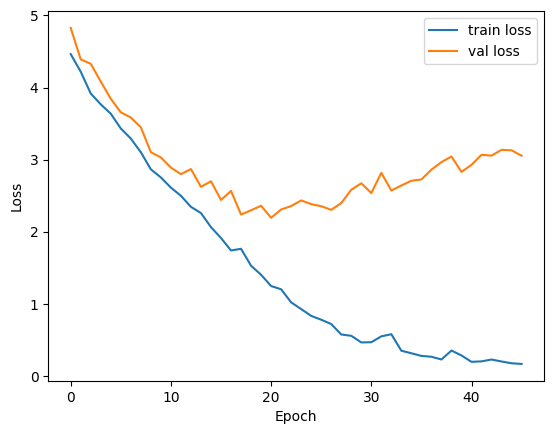

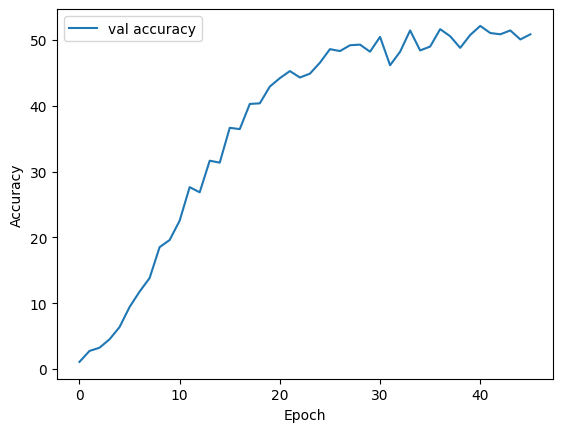

In [ ]:
# plot the graphs
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label="train loss")
plt.plot(val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(val_acc_list, label="val accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()